In [68]:
import numpy as np
import random
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [65]:
class Trader:
    """Represents a single trader on the grid."""   
    def __init__(self, state=0):
        self.state = state

    def activate(self, new_state: int):
        self.state = new_state
    
    def deactivate(self):
        self.state = 0

class Market:
    """Represents a grid of traders."""
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        self.grid = np.array([[Trader() for _ in range(width)] for _ in range(height)])

    def activate_traders(self, percentage: float):
        """Activate traders on grid."""
        num_active_traders = int(percentage * self.width * self.height)
        
        r_idx = np.random.randint(0, self.height, num_active_traders)
        c_idx = np.random.randint(0, self.width, num_active_traders)
        
        [self.grid[r, c].activate(np.random.choice([1, -1])) for r, c in zip(r_idx, c_idx)]

    def get_neighbors(self, x: int, y: int):
        """Get the neighbors of a cell at position (x, y) based on Von Neumann neighborhood."""
        neumann_directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        return [
            (nx, ny)
            for dx, dy in neumann_directions
            if 0 <= (nx := x + dx) < self.height and 0 <= (ny := y + dy) < self.width
        ]
    
    def grid_state(self):
        """Return the grid state for visualization."""
        return [[trader.state for trader in row] for row in self.grid]
    
    def plot_current_state(self):
        """Plot the market grid."""
        state_matrix = np.array([[trader.state for trader in row] for row in self.grid])

        cmap = mcolors.ListedColormap(['red', 'white', 'green'])
        bounds = [-1, 0, 1, 2]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        # Plotting the grid
        plt.imshow(state_matrix, cmap=cmap, norm=norm)
        plt.title("Market Space")
        plt.axis('off')
        plt.show()



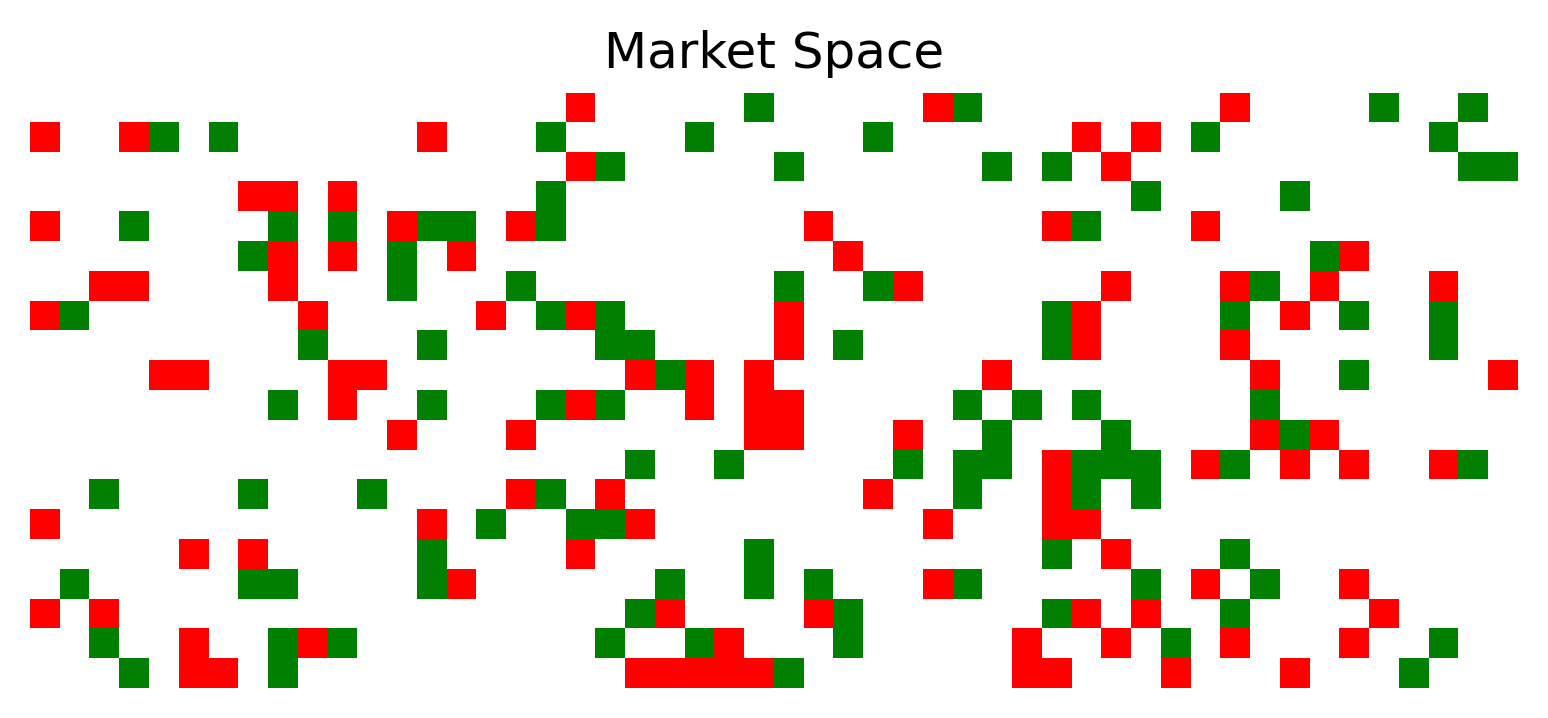

In [ ]:
# Check if implementations are correct
crude_oil = Market(50, 20)
crude_oil.activate_traders(0.25)
crude_oil.get_neighbors(3, 3)
crude_oil.plot_current_state()


In [66]:
import numpy as np
import random

class PercolationDynamics:
    def __init__(self, ph, pd, pe):
        self.pe = pe  # Probability of spontaneous activation
        self.ph = ph  # Probability of neighbor activation
        self.pd = pd  # Probability of diffusion (becoming inactive)

    def update_trader(self, grid, x, y, updates):
        """Update the state of a trader at position (x, y) based on dynamics, and record changes."""
        BUYER, INACTIVE, SELLER = 1, 0, -1
        trader = grid.grid[x][y]

        if trader.state == INACTIVE:
            # Spontaneous activation
            if np.random.random() < self.pe:
                updates.append((x, y, np.random.choice([BUYER, SELLER])))
        else:
            # Count inactive neighbors
            inactive_neighbors = sum(
                1 for nx, ny in grid.get_neighbors(x, y) if grid.grid[nx][ny].state == INACTIVE
            )
            # Proportional diffusion (become inactive)
            if np.random.random() < self.pd * inactive_neighbors:
                updates.append((x, y, INACTIVE))
            else:
                # Neighbor activation
                for nx, ny in grid.get_neighbors(x, y):
                    neighbor = grid.grid[nx][ny]
                    if neighbor.state == INACTIVE and np.random.random() < self.ph:
                        updates.append((nx, ny, np.random.choice([BUYER, SELLER])))

    def apply_updates(self, grid, updates):
        """Apply the queued updates to the grid."""
        for x, y, new_state in updates:
            grid.grid[x][y].state = new_state

    def update_grid(self, grid):
        """Update the entire grid in a way that respects the sequential nature of updates."""
        updates = []

        # Iterate through each cell in the grid to collect changes
        for x in range(len(grid.grid)):
            for y in range(len(grid.grid[0])):
                self.update_trader(grid, x, y, updates)

        # Apply the updates after the full grid has been processed
        self.apply_updates(grid, updates)



In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_market(market, dynamics, num_steps=100):
    # Initialize the grid states for animation
    grid_states = []
    
    # Set up the figure and axes for both grid and line plot
    fig, (ax, ax_line) = plt.subplots(2, 1, figsize=(8, 12))

    # Initialize grid plot
    grid_plot = ax.imshow(
        np.zeros((market.height, market.width)), cmap="coolwarm", vmin=-1, vmax=1
    )
    ax.set_title("Cellular Automata (Grid)")
    ax.axis("off")

    # Set up the line plot for tracking buyers, sellers, and total participants
    buyers_line, = ax_line.plot([], [], label="Buyers (1)", color="blue")
    sellers_line, = ax_line.plot([], [], label="Sellers (-1)", color="red")
    total_line, = ax_line.plot([], [], label="Total Participants", color="green")

    ax_line.set_title("Market Participation Over Time")
    ax_line.set_xlim(0, num_steps)
    ax_line.set_ylim(0, market.width * market.height)  # Max total participants
    ax_line.set_xlabel("Steps")
    ax_line.set_ylabel("Count")
    ax_line.legend()

    def update(frame):
        """Update function for each animation frame."""
        # Perform one step of the dynamics
        dynamics.update_grid(market)

        # Capture grid state
        grid_state = np.array(market.grid_state())
        grid_states.append(grid_state)

        # Update grid plot
        grid_plot.set_array(grid_states[frame])

        # Count the number of buyers, sellers, and total participants
        buyers_count = np.sum(grid_state == 1)
        sellers_count = np.sum(grid_state == -1)
        total_participants = np.abs(grid_state).sum()

        # Update the line plot
        buyers_line.set_data(range(frame + 1), [np.sum(grid_state == 1) for grid_state in grid_states[:frame + 1]])
        sellers_line.set_data(range(frame + 1), [np.sum(grid_state == -1) for grid_state in grid_states[:frame + 1]])
        total_line.set_data(range(frame + 1), [np.abs(grid_state).sum() for grid_state in grid_states[:frame + 1]])

        return grid_plot, buyers_line, sellers_line, total_line

    # Create the animation
    ani = FuncAnimation(fig, update, frames=num_steps, interval=200, blit=True)

    # Display the animation in the notebook
    return HTML(ani.to_html5_video())


In [ ]:
# Example usage
pd = 0.05 * 8
pe = 0.001 * 8
ph = 0.0485 * 8
width, height = 126, 18
market = Market(width, height)
market.activate_traders(0.50)
dynamics = PercolationDynamics(ph=ph, pd=pd, pe=pe)

animate_market(market, dynamics, num_steps=200)